# Simulation Molecular Traffic Jam

Simulation of traffic jam formation with molecular motors based on the Gillespie algorithm. 



In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import os
from parameters import ParameterSet

In [2]:
# Set default folder
ROOT  = os.getcwd()

sys.path.insert(0, ROOT)

## Define simulation parameters


In [3]:
simParameters = {}

# Determine type of dynein: 'WT' (Wild-Type) or 'SP' (Super-Processive)
simParameters['Type'] = 'SP'

# Basic lattice unit is size of motor step, for dynein the step size is 24 nm
simParameters['step'] = 24

simParameters['L'] = 100 # Length lattice in hopping units
simParameters['L_max'] = 300 # Max length lattice in hopping units
simParameters['L_min'] = 30 # Min length lattice in hopping untis

simParameters['R_max'] = 20000 # Maximum number of simulation steps
simParameters['T_max'] = 500 # Max simulated time (in seconds)
simParameters['MTs'] = 10 # Number of traffic jams to simulate

# Determine the sampling interval for saving the lattice configuration
# If sampling = 0, then only the last state will be saved. Otherwise, it
# determines the time interval (in seconds) at which to sample the output.
simParameters['sampling'] = 0

## Define characteristics of the molecular motor

The runlength and velocity parameters for the dynein are taken from Cho et al. JCB 2008.  

Wild type yeast dynein:
* Runlength = 2.25 ± 0.14 um
* Velocity  = 73.9 ± 34.2 nm/sec  

Super processive yeast dynein:
* Runlength = 4.39 ± 0.45 um
* Velocity  = 60.6 ± 18.9 nm/sec

In [4]:
if simParameters['Type'] == 'WT':
    simParameters['Conc'] = 1.45 # Concentration in nM
    simParameters['k_on'] = 0.0025 # Attachment rate [/nM/sec]
    simParameters['k_off'] = 73.9/2250 # Detachment rate bulk [/sec]
    simParameters['k_off_end'] = simParameters['k_off'] # Detachment rate end lattice [/sec]
    simParameters['k_hop'] = 73.9/simParameters['step'] # Forward hopping rate [sites/sec]        
    
elif simParameters['Type'] == 'SP':
    simParameters['Conc'] = 1 # Concentration in nM
    simParameters['k_on'] = 0.0025 # Attachment rate [/nM/sec]
    simParameters['k_off'] = 60.6/4390 # Detachment rate bulk [/sec]
    simParameters['k_off_end'] = simParameters['k_off'] # Detachment rate end lattice [/sec]
    simParameters['k_hop'] = 60.6/simParameters['step'] # Forward hopping rate [sites/sec]  

In [5]:
simPa = ParameterSet(simParameters)

### Function to calculate the propensity of each event

Event 1) Attachment of a particle to an empty spot    
Event 2) Detachment of a particle from an occupied spot   
Event 3) Detachment of a particle from the lattice end  
Event 4) Forward hopping  
 

In [6]:
# Function: Probability of each event
def probability(rates, lattice):
    
    N_events = np.zeros(4)
    Location_events = [None]*4
    
    # Empty sites    
    N_events[0] = (lattice == 0).sum()
    Location_events[0] = np.nonzero(lattice == 0)[0]
    
    # Occupied sites (excluding lattice end)
    N_events[1] = (lattice[:-1] == 1).sum()
    Location_events[1] = np.nonzero(lattice[:-1] == 1)[0]
    
    # Lattice end
    N_events[2] = (lattice[-1] == 1).sum()
    Location_events[2] = np.nonzero(lattice[-1] == 1)[0]
    
    # Hopping events
    D_events = np.diff(lattice)
    N_events[3] = (D_events == -1).sum()    
    Location_events[3] = np.nonzero(D_events == -1)[0]
    
    # Calculate propensities of each event
    pp = np.multiply(rates, N_events)
        
    return Location_events, pp  

### Function to update lattice state


In [7]:
# Function: update state of lattice
def updateState(event, selection, state):
    
    # Attachment event       
    if event == 0:
        index = np.random.randint(len(selection))
        state[selection[index]] += 1
            
    # Detachment event lattice
    elif event == 1:
        index = np.random.randint(len(selection))
        state[selection[index]] -= 1
                    
    # Detachment event lattice end
    elif event == 2:
        state[-1] -= 1

    # Forward hopping event
    elif event == 3:
        index = np.random.randint(len(selection))
        state[selection[index]] -= 1
        state[selection[index]+1] += 1
       
    return state

### Function: Gillespie simulation

In [8]:
def gillespie(simPa):            
    
    # Extract simulation parameters
    rates = [simPa.Conc*simPa.k_on, simPa.k_off, simPa.k_off_end, simPa.k_hop]

    # Initialize simulation
    R_counter = 0
    tt = 0

    # Initialize output
    lattice_cont = [np.zeros(simPa.L)]
    tt_cont = np.zeros(1)

    # Draw randum numbers
    rand_nums = np.random.rand(2,simPa.R_max)

    # Run Gillespie simulation
    while simPa.R_max > R_counter and simPa.T_max+1 > tt:
         
        # Calculate probability for all events
        state = lattice_cont[R_counter]
        [Position_events, pp] = probability(rates, state)

        # Draw waiting time
        delta_t = -np.log(rand_nums[0][R_counter]) / np.sum(pp)

        # Construct intervals
        valid_inds = pp > 0 # Find the possible events
        valid_pp = pp[valid_inds] # Include only valid events
        valid_changes = np.nonzero(valid_inds)[0]       
        
        # Stop current simulation if no valid changes are possible
        if len(valid_changes) == 0:
            break   

        # Construct intervals
        selection_interval = np.cumsum(valid_pp) # Cumulative sum
        selection_interval = selection_interval/selection_interval[-1] # Normalize to [0,1]

        # Select interval
        selected_ind = np.nonzero(selection_interval > rand_nums[1][R_counter])[0][0]
        update_ind = Position_events[valid_changes[selected_ind]]

        # Update lattice configuration
        state_new = updateState(valid_changes[selected_ind], update_ind, state)
        lattice_cont = np.vstack((lattice_cont, state_new))

        # Update time and simulation counter
        tt += delta_t
        tt_cont = np.append(tt_cont, tt)
        R_counter +=1
        
    return lattice_cont, tt_cont              

In [27]:
# Run single simulation
[L, T] = gillespie(simPa)    

0.09094045130654782


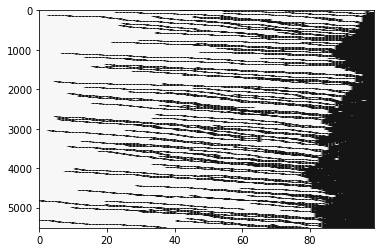

In [28]:
# Plot kymograph of single simulation
fig, ax = plt.subplots()

# Prepare data.
X = np.arange(0,L.shape[1],1)
Y = np.arange(0,len(T),1)
X, Y = np.meshgrid(X, Y)
Z = L

# Plot the filled contour.
plt.contourf(X, Y, Z, cmap='Greys')
ax.set_ylim(len(T),0)
plt.show()

In [ ]:
# Run multiple simulations
for runs in range(simPa.MTs):

    [L, T] = gillespie(simPa)    
    
    # Sample data
    
    # Store Data       
    
    # Save Data
    